<a href="https://colab.research.google.com/github/Ramya0694/algos/blob/master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension adobe-flashplugin
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 13 not upgraded.
Need to get 81.0 MB of archives.
After this operation, 273 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 87.0.4280.66-0ubuntu0.18.04.1 [1,122 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 87.0.4280.66-0ubuntu0.18.04.1 [71.7 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser-l10n all 87.0.428

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import Select
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import gensim
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_driver():
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument("--disable-infobars")
  # open it, go to a website, and get results
  wd = webdriver.Chrome('chromedriver',options=options)
  return wd

In [ ]:
# open it, go to a website, and get results
wd = get_driver()

items = []

for i in range(1,45):
  wd.get('https://alsusweb.lbl.gov:1024/4DCGI/WEB_GetForm/PublicationSearch.shtml/Initialize') 
  select = Select(wd.find_element_by_xpath("//select[@name='PUB_Beamline']"))
  select.select_by_value("8.3.2 (Tomography)")

  wd.find_element_by_name('Submit').click()
  if(i != 1):
    wd.find_element_by_link_text(str(i)).click()

  bs = BeautifulSoup(wd.page_source)
  table = bs.find(lambda tag: tag.name=='table' and tag.has_attr('boarder') and tag['boarder']==" BGCOLOR=") 
  rows = table.findAll(lambda tag: tag.name=='td')

  for row in rows[1:]:
    items.append(row)

In [ ]:
titles = []
hrefs = []

for row in items:
    text = row.get_text()
    href = row.find(lambda tag: tag.name=='a' and tag.has_attr('href'))
    if(href):
      hrefs.append(href['href'])
    else:
      hrefs.append("")
    start = text.index("\"")
    text1 = text[start:]
    title = text1.split("\"")[1]
    titles.append(title)

In [ ]:
def preprocess_lda(data):
  stop_words = stopwords.words('english')

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  data_words_nostops = remove_stopwords(data)

  # Create Dictionary 
  id2word = corpora.Dictionary(data_words_nostops)  
  # Create Corpus 
  texts = data_words_nostops  
  # Term Document Frequency 
  corpus = [id2word.doc2bow(text) for text in texts]  

  words = []
  for word in texts:
    words.extend(word)

  return corpus, id2word, words

In [ ]:
corpus, id2word, words = preprocess_lda(titles)

In [ ]:
# topics = lda_model.get_topics()
# # sim = []

# # for i in range(10):
# #   for j in range(i,10):
# #     cs = cosine_similarity(topics[i], topics[j]) 
# #     sim.append(cs)

# all_sims = cosine_similarity(topics)  # all pairwise similarities
# all_sims.mean()

0.3715517

In [ ]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('drive/MyDrive/LBNL/GoogleNews-vectors-negative300.bin', binary=True)
# Access vectors for specific words with a keyed lookup:
vector = model['easy']
# see the shape of the vector (300,)
vector.shape
# Processing sentences is not as simple as with Spacy:
# vectors = [model[x] for x in "This is some text I am processing with Spacy".split(' ')]

(300,)

In [ ]:
def get_sim(num_topics):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

  similarity_list = []

  for i in range(num_topics):
    terms_1 = [id2word[term[0]] for term in lda_model.get_topic_terms(i)]
    for j in range(i,num_topics):
      terms_2 = [id2word[term[0]] for term in lda_model.get_topic_terms(j)]
      cs = 0
      count = 0
      # print(terms_1, terms_2)
      for val1 in terms_1:
        for val2 in terms_2:
          # print(val1,val2)
          if(val1 in model and val2 in model):
            count += 1
            cs += cosine_similarity(model[[val1]],model[[val2]])[0][0]
      cs = cs/count
      similarity_list.append(cs)
      # print(count)

  return np.array(similarity_list).mean()

x = range(5,50,5)
topic_sim_num = []

for i in x:
  a = get_sim(i)
  print(a)
  topic_sim_num.append(a)

0.1720442060098673
0.14868157073165905
0.14806278182411206
0.14119866497131087
0.13456991750239486
0.13655664064268147
0.12856989346345232
0.13420729924862024
0.1266960354480376


Text(0, 0.5, 'Topic similarity (Cosine)')

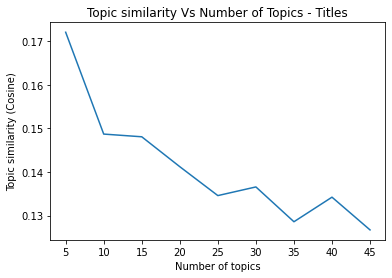

In [ ]:
plt.plot(x,topic_sim_num)
plt.title("Topic similarity Vs Number of Topics - Titles")
plt.xlabel("Number of topics")
plt.ylabel("Topic similarity (Cosine)")

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=25, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

In [ ]:
# for topic in lda_model.print_topics():
#   print(topic)

for i in range(25):
  terms = lda_model.get_topic_terms(i)
  print([id2word[term[0]] for term in terms])

['scale', 'study', 'carbon', 'transport', 'modeling', 'direct', 'oxidation', 'pore', 'media', 'experimental']
['bone', 'water', 'pressure', 'porosity', 'uptake', 'properties', 'thermal', 'pore', 'pbx', 'leaf']
['mechanical', 'size', 'high', 'based', 'properties', 'vitis', 'vinifera', 'bone', 'scaffolds', 'fabrication']
['porous', 'scale', 'modeling', 'layers', 'numerical', 'study', 'transport', 'pumice', 'energy', 'sic']
['solid', 'materials', 'biological', 'lithium', 'electrolyte', 'batteries', 'rhizosphere', 'multiple', 'using', 'synchrotron']
['dimensional', 'micro', 'ct', 'using', 'segmentation', 'materials', 'multiscale', 'energy', 'two', 'three']
['study', 'growth', 'structure', 'strength', 'across', 'thermal', 'textile', 'composites', 'ceramic', 'dimensional']
['tomography', 'ray', 'computed', 'using', 'micro', 'high', 'synchrotron', 'resolution', 'situ', 'water']
['using', 'synchrotron', 'effects', 'radiation', 'microtomography', 'prediction', 'imaging', 'bone', 'properties', '

In [ ]:
# for href in hrefs[0:15]:
#   if(len(href) > 0):
#     wd1 = get_driver()
#     wd1.get(href) 
#     # print(wd1.page_source)
#     bs = BeautifulSoup(wd1.page_source)
#     ps = bs.find(lambda tag: tag.name=='p')
#     print(ps)

In [ ]:
# # open it, go to a website, and get results
# wd = get_driver()

# items = []

# for i in range(1,2):
#   wd.get('https://alsusweb.lbl.gov:1024/4DCGI/WEB_GetForm/PublicationSearch.shtml/Initialize') 
#   select = Select(wd.find_element_by_xpath("//select[@name='PUB_Beamline']"))
#   select.select_by_value("8.3.2 (Tomography)")

#   wd.find_element_by_name('Submit').click()
#   time.sleep(5)
#   link = wd.find_element_by_link_text("(doi:10.1089/3dp.2019.0200)")
#   wd.execute_script('arguments[0].click()', link)
#   # wd.find_element_by_partial_link_text("(doi:10.1089/3dp.2019.0200)").click()
#   # print(link.get_attribute('href'))

#   bs = BeautifulSoup(wd.page_source,'html5lib')
#   ps = bs.find(lambda tag: tag.name=='p') 
#   print(ps)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_table('Pubs.xls')
abstracts = list(df[~df['Abstract'].isna()]['Abstract'])

In [ ]:
corpus_abs, id2word_abs, words_abs = preprocess_lda(abstracts)

In [ ]:
def get_sim(num_topics):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                            id2word=id2word_abs,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

  similarity_list = []

  for i in range(num_topics):
    terms_1 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(i)]
    for j in range(i,num_topics):
      terms_2 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(j)]
      cs = 0
      count = 0
      # print(terms_1, terms_2)
      for val1 in terms_1:
        for val2 in terms_2:
          # print(val1,val2)
          if(val1 in model and val2 in model):
            count += 1
            cs += cosine_similarity(model[[val1]],model[[val2]])[0][0]
      cs = cs/count
      similarity_list.append(cs)
      # print(count)

  return np.array(similarity_list).mean()

x = range(5,50,5)
topic_sim_num = []

for i in x:
  a = get_sim(i)
  print(a)
  topic_sim_num.append(a)

0.14347996662630855
0.1331232863701999
0.1282598894481103
0.12348910123845083
0.1222129035972635
0.12174680032493819
0.124699498956117
0.11900004271030581
0.11862458619543913


Text(0, 0.5, 'Topic similarity (Cosine)')

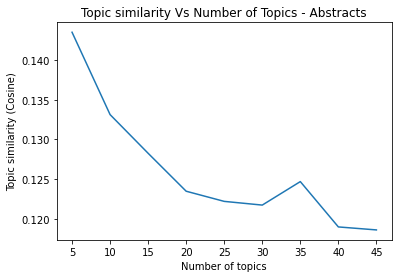

In [ ]:
plt.plot(x,topic_sim_num)
plt.title("Topic similarity Vs Number of Topics - Abstracts")
plt.xlabel("Number of topics")
plt.ylabel("Topic similarity (Cosine)")

In [ ]:
len(titles),len(abstracts)

(395, 257)

In [ ]:
lda_model_abs = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                           id2word=id2word_abs,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
for i in range(10):
  terms = lda_model_abs.get_topic_terms(i)
  print([id2word_abs[term[0]] for term in terms])

['energy', 'mechanical', 'ash', 'properties', 'scaffolds', 'structure', 'conversion', 'high', 'analysis', 'different']
['sup', 'pumice', 'phase', 'ray', 'eruption', 'high', 'magma', 'samples', 'using', 'water']
['bone', 'crack', 'properties', 'toughness', 'fracture', 'growth', 'age', 'trabecular', 'strength', 'human']
['ray', 'fracture', 'cement', 'ct', 'tomography', 'mechanical', 'properties', 'collagen', 'study', 'using']
['xylem', 'water', 'vessel', 'embolism', 'vessels', 'drought', 'species', 'hydraulic', 'plant', 'plants']
['magma', 'specimens', 'cell', 'computed', 'textile', 'alteration', 'mode', 'mixing', 'tomography', 'conditions']
['lithium', 'inf', 'sup', 'batteries', 'density', 'scaffolds', 'solid', 'electrolyte', 'dendrite', 'porosity']
['data', 'inf', 'ray', 'area', 'experiments', 'surface', 'using', 'experimental', 'rates', 'carbonate']
['bone', 'ray', 'water', 'cells', 'catalyst', 'scales', 'tomography', 'transport', 'fracture', 'mineral']
['inf', 'data', 'pore', 'materi

In [ ]:
indices = df['Title'].isna()
df.loc[indices,'Title'] = ""

In [ ]:
indices = df['Abstract'].isna()
df.loc[indices,'Abstract'] = ""

In [ ]:
df['Combined'] = df['Title'] + " " + df['Abstract']

In [ ]:
combined = list(df['Combined'])

In [ ]:
corpus_comb, id2word_comb, words_comb = preprocess_lda(combined)

0.41467923
0.3468267
0.31986806
0.2649727
0.25188085
0.24895754
0.21908581
0.19346125
0.18586199
0.16839004
0.1684649
0.15296063


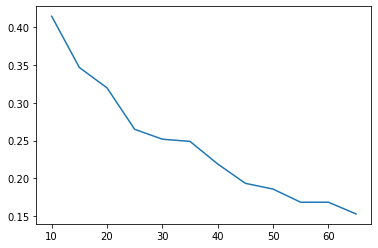

In [ ]:
def get_sim(num_topics):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_comb,
                                            id2word=id2word_comb,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

  topics = lda_model.get_topics()
  all_sims = cosine_similarity(topics)  # all pairwise similarities
  return all_sims.mean()

x = range(10,70,5)
topic_sim_num = []

for i in x:
  a = get_sim(i)
  print(a)
  topic_sim_num.append(a)

plt.plot(x,topic_sim_num)

In [ ]:
lda_model_comb = gensim.models.ldamodel.LdaModel(corpus=corpus_comb,
                                           id2word=id2word_comb,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
for i in range(25):
  terms = lda_model_comb.get_topic_terms(i)
  print([id2word_comb[term[0]] for term in terms])

['water', 'transport', 'scale', 'ray', 'porous', 'tomography', 'pore', 'layers', 'gas', 'diffusion']
['vessel', 'xylem', 'vessels', 'plant', 'tomography', 'ray', 'connections', 'using', 'species', 'water']
['scaffolds', 'bone', 'inf', 'glass', 'nb', 'zr', 'pore', 'bioactive', 'structures', 'repair']
['advanced', 'source', 'experiments', 'data', 'volume', 'synchrotron', 'light', 'algorithms', 'new', 'dentin']
['sup', 'ray', 'synchrotron', 'using', 'formation', 'species', 'tomography', 'high', 'pressure', 'eruption']
['textile', 'data', 'nzvi', 'tomography', 'pd', 'tow', 'carbon', 'stochastic', 'specimens', 'solder']
['image', 'analysis', 'area', 'using', 'algorithm', 'data', 'algorithms', 'study', 'estimates', 'parallel']
['ray', 'pore', 'flow', 'data', 'permeability', 'study', 'using', 'used', 'temperature', 'synchrotron']
['magma', 'host', 'mixing', 'data', 'dike', 'phase', 'genes', 'latent', 'inoculated', 'enclaves']
['inf', 'xylem', 'water', 'hydraulic', 'pumice', 'flow', 'sup', 'em

In [ ]:
len(titles), len(abstracts)

(395, 257)